# Ejercicio 1
<p style="text-align:right;" >Armando Olivares</p><br>

 Una empresa reparte la producción de una mercancía en I plantas distintas para luego distribuirla en J mercados situados en ciudades diferentes. Para i = 1,...,I y j = 1,...,J, disponemos de los siguientes datos:
 * vi ≡ coste variable de producción de una unidad de producto en la planta i. 
 * cij ≡ coste de enviar una unidad de producto desde la planta i al mercado j. 
 * dj ≡ demanda del producto en el mercado j. 
 * Mi ≡ número máximo de productos que se pueden fabricar en la planta i. 
 * pj ≡ precio de venta de cada producto en el mercado j. 
 * F ≡capacidad máxima de transporte entre planta i y mercado j (asumimos todas iguales).


<br>
<br>
a) (1.5 puntos) Bajo este contexto, formula el problema lineal (formulación general) de maximización del beneﬁcio de la empresa (ingresos totales por venta - costes totales de producción y transporte) mediante la asignación óptima de producción en plantas y reparto entre los mercados. Asume que la demanda de cada mercado se debe satisfacer con igualdad (“productos que llegan al mercado j” = dj)

<br>
Nos encontramos ante una variante del problema del transporte de la forma:
<img src="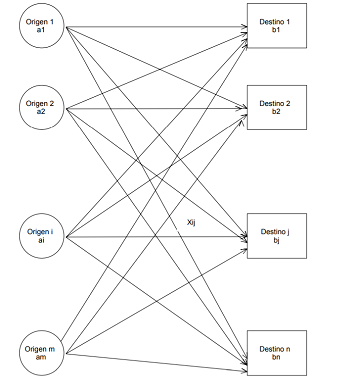
" >

<div><p style="text-align:center; font-weight: bold">La solución a este problema se traduce a Maximizar la siguiente función objetivo:</p></div><br>

## Formulación General 


\begin{align*}
\underset{x_{ij}}{\max} & \quad \sum_{j=1}^{m}p_{j}\sum_{i=1}^{n}x_{ij}-\sum_{i=1}^{n}\sum_{j=1}^{m}(c_{ij}x_{ij}) -\sum_{i=1}^{m}v_{i}\sum_{j=1}^{n} x_{ij} \\
\text{s.t.:}&\\
  &\sum_{i=1}^{n} x_{ij} = d_{j} \quad \forall j  \,\,(Restricción\, de\, Demanda)\\
  &\sum_{j=1}^{m} x_{ij} \leq M_{i} \quad \forall i\,\,(Restricción\, de\, Oferta)\\
  &x_{i} \geq 0 \quad \forall i \\
  &x_{ij} \leq F_{ij} \quad \forall i,j \,\,(Restrición\, de\, Transporte)\\
\end{align*}



(2 puntos) Implementa el modelo en Pyomo como “AbstractModel()” y resuélvelo considerando 5 plantas y 6 mercados generando valores aleatórios de los parámetros. Para la generación aleatória considera distribuciones uniformes en los siguientes rangos: vi ∈ [1.5,2.5], ci,j ∈ [1,2], dj ∈ [275,325], Mi ∈ [400,900], pj ∈ [4,5] y F ∈ [250,350]. 

In [227]:


%%writefile transportation_gen.py

from __future__ import division 
from pyomo.environ import *
import numpy as np
model = AbstractModel()


model.n = Param(within=NonNegativeIntegers)
model.m = Param(within=NonNegativeIntegers)

model.I = RangeSet(1,model.n) 
model.J = RangeSet(1,model.m)

model.v= Param(model.I) #transportation costs per unit
model.c = Param(model.I, model.J) #trasportation cost
model.p = Param(model.J) #price for each market
model.d = Param(model.J) #demand for each market
model.f = Param(model.I, model.J) #maximim transportation capacity
model.M = Param(model.I) #maximum production per factory

# the next line declares a variable indexed by the set J 
#model.x = Var(model.I,model.J, domain=NonNegativeReals)
model.x = Var(model.I,model.J, domain=NonNegativeReals)

#definition of the objective function
def obj_expression(model): 
    return sum(sum(model.x[i,j] for i in model.I)*model.p[j] for j in model.J )- (sum(model.x[i,j]*model.c[i,j] for i in model.I for j in model.J ))-sum(sum(model.x[i,j] for j in model.J)*model.v[i] for i in model.I )

model.OBJ = Objective(rule=obj_expression,sense=maximize )

#Demand constraint
def d_constraint_rule(model, j): # return the expression for the constraint for i
    return sum(model.x[i,j] for i in model.I)>= model.d[j]

# the next line creates one constraint for each member of the set model.J 
model.dem_Constraint = Constraint(model.J, rule=d_constraint_rule)

#maximum transport constraint
def f_constraint_rule(model, i,j): # return the expression for the constraint for i
    return (model.x[i,j] )<= model.f[i,j]

model.tx_Constraint = Constraint(model.I,model.J, rule=f_constraint_rule)


#maximum production constraint
def a_constraint_rule(model, i): # return the expression for the constraint for i
    return sum(model.x[i,j] for j in model.J)<= model.M[i]

model.prod_Constraint = Constraint(model.I, rule=a_constraint_rule)


Overwriting transportation_gen.py


Para la generación aleatória considera distribuciones uniformes en los siguientes rangos: vi ∈ [1.5,2.5], ci,j ∈ [1,2], dj ∈ [275,325], Mi ∈ [400,900], pj ∈ [4,5] y F ∈ [250,350]. 

Generamos los valores y definimos la función para guardar los datos en formato **AMPL**

In [228]:
n = 5 #nro plantas
m = 6 #nro mercados
np.random.seed(2)
v= np.random.uniform(1.5,2.5, size=(n,1))
c = np.random.uniform(1,2, size=(n,m))
d = np.random.randint(275,325, size=(6,1))
M = np.random.randint(400,900, size=(n,1))  
p = np.random.uniform(4.0,5.0, size=(6,1))
f = (np.random.randint(250,350, [n,m]))
f
str_for_amlp = "param n:= "+str(n)+";\n"
str_for_amlp += "param m:= "+str(m)+";\n"

def format_ampl(vector):
    c = vector
    str_param_c =""
    if c.shape[1] == 1:
        for i, value in enumerate(c):
            #print(j+1, value)
            str_param_c += str(i+1)+" "+str(value).replace('[','').replace(']','')+"\n"
    else:
        for i,row in enumerate(c):
            #print(i, row)
            for j, value in enumerate(row):
                #print(j+1, value)
                str_param_c += str(i+1)+" "+str(j+1)+" "+str(value)+"\n"
    return (str_param_c+ ";\n")


Generamos el Archivo de Datos:

In [229]:
#%%writefile transportation_gen.dat
str_for_amlp +="param v:= \n"+format_ampl(v)+ "param c:= \n"+ format_ampl(c)+ "param d:= \n" +\
                format_ampl(d)+ "param M:= \n"+ format_ampl(M)+"param p:= \n"+format_ampl(p)+\
                "param f:= \n"+format_ampl(f)
with open("output.dat", "w") as text_file:
    text_file.write(str_for_amlp)

Resolvemos con **pyomo**

In [230]:
!pyomo solve transportation_gen.py output.dat --solver=glpk --summary --solver-suffix=dual

[    0.00] Setting up Pyomo environment
[    0.00] Applying Pyomo preprocessing actions
[    0.02] Creating model
[    0.10] Applying solver
[    0.24] Processing results
    Number of solutions: 1
    Solution Information
      Gap: 0.0
      Status: feasible
      Function Value: 4400.608110706027
    Solver results file: results.yml

Solution Summary

Model unknown

  Variables:
    x : Size=30, Index=x_index
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 1) :     0 :  53.0 :  None : False : False : NonNegativeReals
        (1, 2) :     0 : 336.0 :  None : False : False : NonNegativeReals
        (1, 3) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (1, 4) :     0 : 151.0 :  None : False : False : NonNegativeReals
        (1, 5) :     0 : 306.0 :  None : False : False : NonNegativeReals
        (1, 6) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 1) :     0 :   0.0 :  None : False : False : NonNegativeReals
  

**Con este modelo podemos optimizar la ganancia hasta un valor de *4400* **

Revisamos el Resultado:

In [231]:
!type results.yml

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 4400.60811070603
  Upper bound: 4400.60811070603
  Number of objectives: 1
  Number of constraints: 42
  Number of variables: 31
  Number of nonzeros: 91
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.09274649620056152
# ----------------------------------------------------------
#   Solution Information
# ------------

**Leemos el archivo del resultado y lo imprimimos en un mejor formato para visualizar la matrix fábrica vs mercados:**

In [232]:
with open('results.yml', 'r') as f:
    #print(f.read())
    file =f.read()
x= np.zeros([5,6])
for i, row in enumerate(x):
    for j, value in enumerate(row):
        if file.find("x["+str(i+1)+","+str(j+1)+"]") != -1:
            x[i,j] = int(file[file.find("x["+str(i+1)+","+str(j+1)+"]")+20:file.find("x["+str(i+1)+","+str(j+1)+"]")+25])
print(x)

[[  53.  336.    0.  151.  306.    0.]
 [   0.  318.    0.  165.    0.    0.]
 [   0.    0.  159.    0.  337.    0.]
 [   0.    0.    0.    0.  340.  103.]
 [ 239.    0.  125.    0.  126.  198.]]


Observamos qué planta está produciendo más y cúal fue el mercado que más productos recibió:

In [233]:
print("La Producción: ",x.sum(axis=1))
print("Lo distribuido por Mercado: ",x.sum(axis=0))
print("Los precios por Mercado :", p.T)
print("La Demanda por Mercado :", d.T)

La Producción:  [ 846.  483.  496.  443.  688.]
Lo distribuido por Mercado:  [  292.   654.   284.   316.  1109.   301.]
Los precios por Mercado : [[ 4.34161365  4.56714413  4.42754596  4.43674726  4.77655918  4.53560417]]
La Demanda por Mercado : [[292 297 284 316 321 301]]


 A la vista de los resultados ¿en qué planta sería mejor invertir para ampliar su capacidad? y ¿en qué mercado sería más beneﬁcioso incrementar la demanda? Razona tus respuestas.


Tenemos que la planta que más produce en la planta número **1** con **846 productos**, sin embargo está planta atiende a 4 mercados tal vez podriamos incrementar su capacidad de producción para lograr una mayor distribución, principalmente al mercado **5** el cual es el que más demanda de productos tiene y también tiene los precios más altos por lo que sería conveniente incrementar la demanda en este mercado.

Modiﬁca el problema de optimización en a) para imponer que cada fábrica pueda suministrar como máximo a 5 mercados (pista: puede ser recomendable el uso de variables binarias). Resuelve el problema en Pyomo e interpreta los resultados.


**Lo que harémos es agregar un nueva matriz binaria que nos sirva de filtro para que las fábricas no envien a más de 5 mercados.**

In [234]:

%%writefile transportation_gen_mod.py

from __future__ import division 
from pyomo.environ import *
import numpy as np
model = AbstractModel()


model.n = Param(within=NonNegativeIntegers)
model.m = Param(within=NonNegativeIntegers)
model.s = Param(within=NonNegativeIntegers)
model.I = RangeSet(1,model.n) 
model.J = RangeSet(1,model.m)

model.v= Param(model.I) #transportation costs per unit
model.c = Param(model.I, model.J) #trasportation cost
model.p = Param(model.J) #price for each market
model.d = Param(model.J) #demand for each market
model.f = Param(model.I, model.J) #maximim transportation capacity
model.M = Param(model.I) #maximum production per factory
model.e =  Var(model.I, model.J, domain=Binary)
# the next line declares a variable indexed by the set J 
#model.x = Var(model.I,model.J, domain=NonNegativeReals)
model.x = Var(model.I, model.J, domain=NonNegativeReals)

#definition of the objective function
#definition of the objective function
def obj_expression(model): 
    return sum(sum(model.x[i,j] for i in model.I)*model.p[j] for j in model.J )- (sum(model.x[i,j]*model.c[i,j] for i in model.I for j in model.J ))-sum(sum(model.x[i,j] for j in model.J)*model.v[i] for i in model.I )

model.OBJ = Objective(rule=obj_expression,sense=maximize )

#Demand constraint
def d_constraint_rule(model, j): # return the expression for the constraint for i
    return sum(model.x[i,j] for i in model.I)>= model.d[j]

# the next line creates one constraint for each member of the set model.J 
model.dem_Constraint = Constraint(model.J, rule=d_constraint_rule)

#maximum transport constraint
def f_constraint_rule(model, i,j): # return the expression for the constraint for i
    return (model.x[i,j] )<= model.f[i,j]*model.e[i,j]

model.tx_Constraint = Constraint(model.I,model.J, rule=f_constraint_rule)


#maximum production constraint
def a_constraint_rule(model, i): # return the expression for the constraint for i
    return sum(model.x[i,j] for j in model.J)<= model.M[i]

model.prod_Constraint = Constraint(model.I, rule=a_constraint_rule)

##Binary constraint rule
def b_constraint_rule(model, i): 
    return (sum(model.e[i,j] for j in model.J)<=model.s )
model.b_Constraint = Constraint(model.I, rule=b_constraint_rule)

Overwriting transportation_gen_mod.py


Generamos nuevamente los datos agregando la variable **s** que no indicará a cuantos mercados máximo debo enviar productos(desde el punto de vista de la fábrica)

In [235]:
with open("output_mod.dat", "w") as text_file:
    text_file.write(str_for_amlp)
s =5
with open("output_mod.dat", "a") as text_file:
    text_file.write("\nparam s:= "+ str(s)+";\n")

In [236]:
!pyomo solve transportation_gen_mod.py output_mod.dat --solver=glpk --summary --solver-suffix=dual

[    0.00] Setting up Pyomo environment
[    0.00] Applying Pyomo preprocessing actions
[    0.02] Creating model
[    0.05] Applying solver
[    0.13] Processing results
    Number of solutions: 1
    Solution Information
      Gap: 0.0
      Status: optimal
      Function Value: 4400.608110706027
    Solver results file: results.yml

Solution Summary

Model unknown

  Variables:
    e : Size=30, Index=e_index
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 1) :     0 :   1.0 :     1 : False : False : Binary
        (1, 2) :     0 :   1.0 :     1 : False : False : Binary
        (1, 3) :     0 :   0.0 :     1 : False : False : Binary
        (1, 4) :     0 :   1.0 :     1 : False : False : Binary
        (1, 5) :     0 :   1.0 :     1 : False : False : Binary
        (1, 6) :     0 :   0.0 :     1 : False : False : Binary
        (2, 1) :     0 :   0.0 :     1 : False : False : Binary
        (2, 2) :     0 :   1.0 :     1 : False : False : Binary
        (

Observamos que la solución no cambia porque ya la condición de envío menor a 5 mercados se cumplía con los datos anteriores.(sin embargo si modificamos la condición a menor a 3 o dos mercados SI se observa el cambio en la solución)

In [237]:
with open('results.yml', 'r') as f:
    file =f.read()
x= np.zeros([5,6])
for i, row in enumerate(x):
    for j, value in enumerate(row):
        if file.find("x["+str(i+1)+","+str(j+1)+"]") != -1:
            x[i,j] = int(file[file.find("x["+str(i+1)+","+str(j+1)+"]")+20:file.find("x["+str(i+1)+","+str(j+1)+"]")+25])
print(x)

[[  53.  336.    0.  151.  306.    0.]
 [   0.  318.    0.  165.    0.    0.]
 [   0.    0.  159.    0.  337.    0.]
 [   0.    0.    0.    0.  340.  103.]
 [ 239.    0.  125.    0.  126.  198.]]
